# nat-Zarcos Analysis Workflow -- v1


This notebook demonstrates the usage of the nat-zacros package for analyzing Zacros simulation data.

(Note: formerly named zacros_analysis_v1.ipynb)


## 1. Setup and Configuration

In [19]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle
from pathlib import Path
import platform
import subprocess
import time


# Get current user's home directory and username
home_dir = Path.home()
username = home_dir.name

# Dictionary mapping usernames to nat-zacros repository paths
nat_zacros_pkg_paths = {
    'a-DJA'  :  home_dir / 'GIT' / 'nat_zacros',
    'akandra':  home_dir / 'git' / 'nat_zacros',
}

# Path to the data
data_path = home_dir / 'Dropbox' / 'Surface_Reaction_Kinetics' / 'O_Pt111' / 'zacros_calculations'

# Get path for current user
try:
    nat_zacros_pkg_dir = nat_zacros_pkg_paths[username]
except KeyError:
    raise ValueError(f"Unknown user: {username}. Add your path to nat_zacros_pkg_paths dictionary.")

if nat_zacros_pkg_dir.exists() and str(nat_zacros_pkg_dir) not in sys.path:
    sys.path.insert(0, str(nat_zacros_pkg_dir))
    print(f"Added to path: {nat_zacros_pkg_dir}")


# -- If we manage to install nat_zacros in editable mode

# import importlib
# importlib.reload(nat_zacros)
# from nat_zacros import lattice, state, trajectory, load_trajectories_parallel

import nat_zacros as nz

print(f"Operating System  : {platform.system()}")
print(f"User              : {username}")
print(f"nat_zacros version: {nz.__version__}")
print(f"nat_zacros folder : {nat_zacros_pkg_dir.as_posix()}")
print(f"Data directory    : {data_path.as_posix()}")

Operating System  : Windows
User              : a-DJA
nat_zacros version: 0.0.2.dev5+g9765084b3.d20260106
nat_zacros folder : C:/Users/a-DJA/GIT/nat_zacros
Data directory    : C:/Users/a-DJA/Dropbox/Surface_Reaction_Kinetics/O_Pt111/zacros_calculations


In [20]:
lat_test = nz.lattice()
lat_test.get_lattice()

nothing to get: lattice folder not defined
test printing


## 2. Specify directories for a group of simulations

In [21]:
# Set directories
log_dir = data_path / 'fn_3leed'
data_dir = log_dir / 'jobs'
results_dir = log_dir / 'results'
log_file = data_dir / 'jobs.log'

# Create results directory
Path.mkdir(results_dir, exist_ok=True)

# Verify the file exists
if not log_file.exists():
    raise FileNotFoundError(f"Log file not found: {log_file}")

# Load json log file
with open(log_file, 'r') as f:
    log_header = f.readline().split()  # Read header
    log_entries = [json.loads(line) for line in f if line.strip()]

# Parse job information
run_dirs = [data_dir / str(entry[0]) for entry in log_entries]
temperatures = [entry[4] for entry in log_entries]
lat_size = [entry[2][0]*entry[2][1] for entry in log_entries]
n_ads = [entry[3][0] for entry in log_entries]
interactions = ['-'.join(entry[5][1:]) for entry in log_entries]
coverages = [n_ads[i]/lat_size[i] for i in range(len(n_ads))]
print(f"Found {len(run_dirs)} simulation runs")

Found 19 simulation runs


## 3. Determine Equilibration Time

**Purpose:** Load full trajectories and plot energy vs time to determine equilibration.

**Workflow:** 
1. Load ALL trajectory data (no equilibration cutoff)
2. Compute average energy vs time
3. Plot and visually inspect to identify equilibration point
4. Use this to set the `fraction` parameter in the next section

Analyzing run : 1
  Temperature : 50 K
  Coverage    : 0.110 ML
  Interactions: 1nn-2nn-3nn-4nn-5nn-6nn-7nn-8nn-9nn-1-1-1-1-1-2-1-1-3-2-2-5-2-2-6-3-3-3-1-2-3
Found 10 trajectories

Loading FULL trajectories with parallel I/O (all data, no cutoff)
Loading 10 trajectories in parallel using 14 workers...


Loading trajectories: 100%|██████████| 10/10 [00:21<00:00,  2.13s/traj]


Successfully loaded 10 trajectories
  Example: 200 states per trajectory

Loading completed in 21.79 seconds

Trajectory info:
  Number of trajectories: 10
  States per trajectory: 200 (full, not equilibrated)
  Total states: 2000

Computing average energy vs time from FULL trajectories
Common time range: 0 to 4.69e+38 s
Binned energy data from 10 trajectories

Energy statistics (after skipping first 5 bins):
  Mean:   1.7154 eV
  Std:    0.6311 eV
  Min:    0.9664 eV
  Max:    4.2075 eV


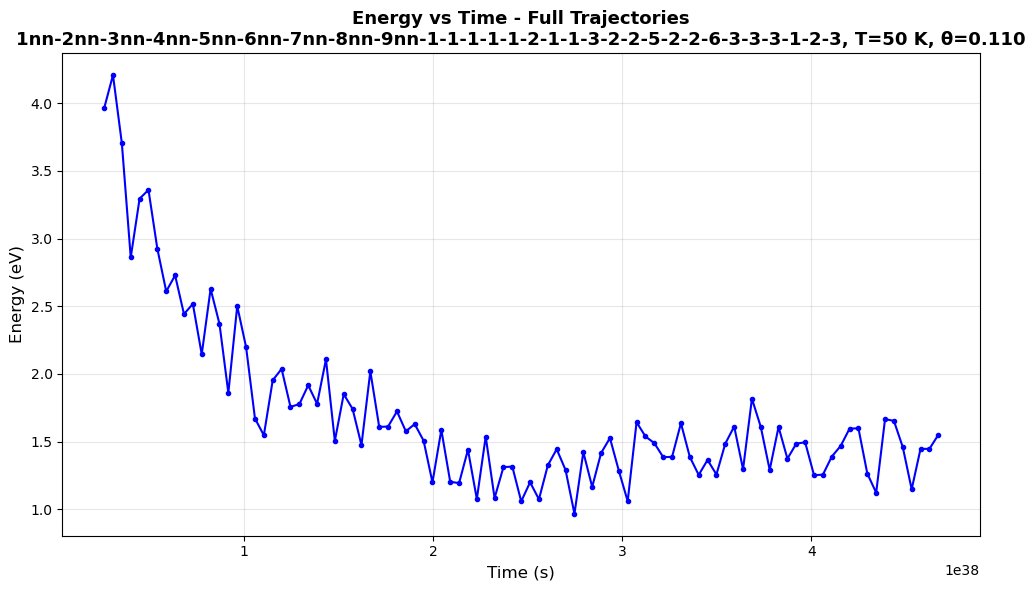


INSPECT THE PLOT ABOVE TO DETERMINE EQUILIBRATION

Visual inspection guidance:
  - Look for where energy stabilizes (becomes roughly constant)
  - Initial transient = equilibration period
  - Choose a fraction to discard (e.g., 0.5 = discard first 50%)

Typical values:
  fraction=0.3 → keep last 30% (long equilibration)
  fraction=0.5 → keep last 50% (moderate equilibration)
  fraction=0.7 → keep last 70% (short equilibration)

Energy statistics (after 50% equilibration):
  Mean:   1.3913 eV
  Std:    0.1828 eV
  Min:    0.9664 eV
  Max:    1.8168 eV


In [22]:
# Select run for analysis
run_number = 0  
rundir = run_dirs[run_number]
print(f"Analyzing run : {rundir.name}")
print(f"  Temperature : {temperatures[run_number]} K")
print(f"  Coverage    : {coverages[run_number]:.3f} ML")
print(f"  Interactions: {interactions[run_number]}")

# Find all trajectory directories
traj_dirs = sorted([d for d in rundir.iterdir() if d.is_dir() and d.name.startswith('traj_')])
print(f"Found {len(traj_dirs)} trajectories")

# Start timing
t_start = time.time()

print("\n" + "="*70)
print("Loading FULL trajectories with parallel I/O (all data, no cutoff)")
print("="*70)

# Create lattice (same for all trajectories)
lat = nz.lattice(traj_dirs[0])

# Load ALL trajectory data (fraction=1.0 means no equilibration cutoff)
trajs_full = nz.load_trajectories_parallel(lat, traj_dirs, fraction=1.0, n_workers=None)

t_elapsed = time.time() - t_start

print(f"\n{'='*70}")
print(f"Loading completed in {t_elapsed:.2f} seconds")
print(f"{'='*70}")
print(f"\nTrajectory info:")
print(f"  Number of trajectories: {len(trajs_full)}")
print(f"  States per trajectory: {len(trajs_full[0])} (full, not equilibrated)")
print(f"  Total states: {sum(len(t) for t in trajs_full)}")

# Extract energy data and plot
print("\n" + "="*70)
print("Computing average energy vs time from FULL trajectories")
print("="*70)

n_time_bins = 100

# Use minimum end time across all trajectories
end_time = min([traj.times[-1] for traj in trajs_full])
print(f"Common time range: 0 to {end_time:.2e} s")

# Create time bins starting from 0 (full trajectory)
time_bins = np.linspace(0, end_time, n_time_bins + 1)
time_bin_centers = 0.5 * (time_bins[:-1] + time_bins[1:])
energy_hist = np.zeros(n_time_bins)

# Accumulate energy from all FULL trajectories
for traj in trajs_full:
    times, energies = traj.get_energy_vs_time()
    
    # Bin the energy values
    for t, energy in zip(times, energies):
        if t <= end_time:
            bin_index = np.digitize(t, time_bins, right=False) - 1
            if 0 <= bin_index < n_time_bins:
                energy_hist[bin_index] += energy

# Average over trajectories
energy_hist /= len(trajs_full)

print(f"Binned energy data from {len(trajs_full)} trajectories")

# Skip first few bins (initialization artifacts)
skip_bins = 5

print(f"\nEnergy statistics (after skipping first {skip_bins} bins):")
print(f"  Mean:   {np.mean(energy_hist[skip_bins:]):.4f} eV")
print(f"  Std:    {np.std(energy_hist[skip_bins:]):.4f} eV")
print(f"  Min:    {np.min(energy_hist[skip_bins:]):.4f} eV")
print(f"  Max:    {np.max(energy_hist[skip_bins:]):.4f} eV")

# Plot energy vs time
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(time_bin_centers[skip_bins:], energy_hist[skip_bins:], 
        marker='o', linestyle='-', markersize=3, linewidth=1.5, color='blue')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Energy (eV)', fontsize=12)
ax.set_title(f'Energy vs Time - Full Trajectories\n{interactions[run_number]}, T={temperatures[run_number]} K, θ={coverages[run_number]:.3f}',
            fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estimate equilibration point
eq_fraction = 0.5
eq_bin = int(eq_fraction * n_time_bins)

print(f"\n{'='*70}")
print("INSPECT THE PLOT ABOVE TO DETERMINE EQUILIBRATION")
print("="*70)
print("\nVisual inspection guidance:")
print("  - Look for where energy stabilizes (becomes roughly constant)")
print("  - Initial transient = equilibration period")
print("  - Choose a fraction to discard (e.g., 0.5 = discard first 50%)")
print("\nTypical values:")
print("  fraction=0.3 → keep last 30% (long equilibration)")
print("  fraction=0.5 → keep last 50% (moderate equilibration)")
print("  fraction=0.7 → keep last 70% (short equilibration)")

print(f"\nEnergy statistics (after {eq_fraction*100:.0f}% equilibration):")
print(f"  Mean:   {np.mean(energy_hist[eq_bin:]):.4f} eV")
print(f"  Std:    {np.std(energy_hist[eq_bin:]):.4f} eV")
print(f"  Min:    {np.min(energy_hist[eq_bin:]):.4f} eV")
print(f"  Max:    {np.max(energy_hist[eq_bin:]):.4f} eV")
print("="*70)

## 4. Load Equilibrated Trajectories with Caching

This cell loads trajectories with equilibration cutoff and demonstrates caching:

1. **Check for cached data** (binary pickle file)
2. **If not cached**: Load using **parallel I/O** with equilibration fraction
3. **Save to cache** for future use

**Performance:**
- First run: ~6-10s (parallel loading)
- Subsequent runs: ~0.5s (cache loading)

**Important:** Set the `fraction` parameter based on the equilibration plot above.

In [23]:
clear_cache = True   # Set to True to force reload

# Use same run_number as above
print(f"Loading equilibrated trajectories for run: {rundir.name}")

# Cache files for this run
cache_file = results_dir / f'{rundir.name}_trajs_eq.pkl'
gref_cache_file = results_dir / f'{rundir.name}_gref.pkl'

# Clear cache if requested
if clear_cache:
    if cache_file.exists():
        cache_file.unlink()
        print(f"Trajectory cache cleared: {cache_file.name}")
    if gref_cache_file.exists():
        gref_cache_file.unlink()
        print(f"g_ref cache cleared: {gref_cache_file.name}")

print(f"\nTrajectory cache: {cache_file.name}")
print(f"  Exists: {cache_file.exists()}")
print(f"g_ref cache: {gref_cache_file.name}")
print(f"  Exists: {gref_cache_file.exists()}")

# If cache exists, show its age and size
if cache_file.exists():
    import datetime
    mod_time = datetime.datetime.fromtimestamp(cache_file.stat().st_mtime)
    size_mb = cache_file.stat().st_size / 1024**2
    print(f"\nTrajectory cache info:")
    print(f"  Modified: {mod_time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"  Size: {size_mb:.1f} MB")

# Start timing
t_start = time.time()

if not cache_file.exists():
    print("\n" + "="*70)
    print("FIRST RUN: Loading trajectories with parallel I/O")
    print("="*70)
    
    # Create lattice (already created above, but recreate for standalone execution)
    lat = nz.lattice(traj_dirs[0])
    
    # Load trajectories in parallel with equilibration cutoff
    # ADJUST fraction based on equilibration plot above
    eq_fraction = 0.5  # Keep last 50% of trajectory
    print(f"Using equilibration fraction: {eq_fraction} (keeping last {eq_fraction*100:.0f}%)")
    trajs = nz.load_trajectories_parallel(lat, traj_dirs, fraction=eq_fraction, n_workers=None)
    
    # Save trajectories to cache
    print(f"\nSaving trajectories to cache: {cache_file.name}")
    with open(cache_file, 'wb') as f:
        pickle.dump(trajs, f)
    print(f"Trajectory cache saved: {cache_file.stat().st_size / 1024**2:.1f} MB")
    
else:
    print("\n" + "="*70)
    print("CACHED: Loading trajectories from pickle file")
    print("="*70)
    
    # Load from cache
    with open(cache_file, 'rb') as f:
        trajs = pickle.load(f)
    print(f"Loaded {len(trajs)} trajectories from cache")

t_load = time.time() - t_start

# =========================================================================
# Compute and cache g_ref (reference RDF for normalization)
# =========================================================================
print("\n" + "="*70)
print("Computing reference RDF (g_ref) for lattice normalization")
print("="*70)

# RDF parameters (must match those used in Section 5)
r_max = 40.0  # Angstrom
dr = 0.1  # Bin width

if not gref_cache_file.exists():
    print("Computing g_ref (one-time calculation per lattice)...")
    t_gref_start = time.time()
    r_ref, g_ref = trajs[0].get_g_ref(r_max=r_max, dr=dr)
    t_gref = time.time() - t_gref_start
    
    print(f"g_ref computed in {t_gref:.2f} seconds")
    print(f"  Array size: {len(g_ref)} bins")
    print(f"  Distance range: 0 to {r_max:.1f} Å")
    
    # Save g_ref to cache
    print(f"\nSaving g_ref to cache: {gref_cache_file.name}")
    with open(gref_cache_file, 'wb') as f:
        pickle.dump((r_ref, g_ref), f)
    print(f"g_ref cache saved: {gref_cache_file.stat().st_size / 1024:.1f} KB")
else:
    print("Loading g_ref from cache...")
    t_gref_start = time.time()
    with open(gref_cache_file, 'rb') as f:
        r_ref, g_ref = pickle.load(f)
    t_gref = time.time() - t_gref_start
    print(f"g_ref loaded from cache in {t_gref:.2f} seconds")
    print(f"  Array size: {len(g_ref)} bins")

t_total = t_load + t_gref

print(f"\n{'='*70}")
print("LOADING SUMMARY")
print(f"{'='*70}")
print(f"Trajectories:  {t_load:6.2f} s")
print(f"g_ref:         {t_gref:6.2f} s")
print(f"Total:         {t_total:6.2f} s")
print(f"\nTrajectory info:")
print(f"  Number of trajectories: {len(trajs)}")
print(f"  States per trajectory: {len(trajs[0])} (equilibrated)")
print(f"  Total states: {sum(len(t) for t in trajs)}")

# Check if this looks like full or equilibrated data
if 'trajs_full' in locals():
    ratio = len(trajs[0]) / len(trajs_full[0])
    print(f"  Equilibration ratio: {ratio:.1%} of full trajectory")
    if ratio > 0.8:
        print(f"  ⚠️  WARNING: Cache may contain nearly full trajectories!")
        print(f"     Consider setting clear_cache=True and rerunning")

print("="*70)

Loading equilibrated trajectories for run: 1
Trajectory cache cleared: 1_trajs_eq.pkl
g_ref cache cleared: 1_gref.pkl

Trajectory cache: 1_trajs_eq.pkl
  Exists: False
g_ref cache: 1_gref.pkl
  Exists: False

FIRST RUN: Loading trajectories with parallel I/O
Using equilibration fraction: 0.5 (keeping last 50%)
Loading 10 trajectories in parallel using 14 workers...


Loading trajectories: 100%|██████████| 10/10 [00:14<00:00,  1.45s/traj]


Successfully loaded 10 trajectories
  Example: 100 states per trajectory (equilibrated)

Saving trajectories to cache: 1_trajs_eq.pkl
Trajectory cache saved: 38.6 MB

Computing reference RDF (g_ref) for lattice normalization
Computing g_ref (one-time calculation per lattice)...
g_ref computed in 15.35 seconds
  Array size: 400 bins
  Distance range: 0 to 40.0 Å

Saving g_ref to cache: 1_gref.pkl
g_ref cache saved: 6.4 KB

LOADING SUMMARY
Trajectories:   15.26 s
g_ref:          15.35 s
Total:          30.61 s

Trajectory info:
  Number of trajectories: 10
  States per trajectory: 100 (equilibrated)
  Total states: 1000
  Equilibration ratio: 50.0% of full trajectory


## 5. Radial Distribution Function (RDF) Analysis

Compute RDF using **vectorized distance calculations** (OPTIMIZATION #1).

**Performance note:** For 10 trajectories, sequential computation with vectorization is fastest (~2s).  
Parallel RDF would be slower due to overhead.

In [24]:
# RDF parameters (must match those in Section 4)
lattice_constant = 2.821135  # 1nn distance in Angstroms (Pt(111))
r_max = 40.0  # Angstrom
dr = 0.1  # Bin width

# g_ref was already computed and cached in Section 4
print("=" * 70)
print("Computing RDF for all trajectories")
print("=" * 70)
print(f"Using cached g_ref from Section 4")
print(f"Total states to process: {sum(len(t) for t in trajs)}")
print(f"States per trajectory: {len(trajs[0])}")

t_start = time.time()

# Compute RDF for each trajectory using vectorized distances
rdfs = []
for i, traj in enumerate(trajs):
    print(f"  Computing RDF {i+1}/{len(trajs)} ({len(traj)} states)...", end='\r')
    r, g = traj.get_rdf(r_max=r_max, dr=dr, g_ref=g_ref, vectorized=True)
    rdfs.append(g)

# Average RDFs across all trajectories
g_avg = np.mean(rdfs, axis=0)
g_std = np.std(rdfs, axis=0)

# Convert distance to units of lattice constant
r_a0 = r / lattice_constant

t_elapsed = time.time() - t_start

print(f"\n\n{'=' * 70}")
print("RDF COMPUTATION COMPLETE")
print("=" * 70)
print(f"Time elapsed: {t_elapsed:.2f} seconds")
print(f"  Trajectories: {len(trajs)}")
print(f"  Total states: {sum(len(t) for t in trajs)}")
print(f"  Average time per trajectory: {t_elapsed/len(trajs):.3f} s")
print(f"  Average time per state: {t_elapsed/sum(len(t) for t in trajs)*1000:.2f} ms")

# Find peak information
peak_idx = np.argmax(g_avg)
print(f"\nRDF Peak Analysis:")
print(f"  Peak position: {r_a0[peak_idx]:.2f} a₀ ({r[peak_idx]:.2f} Å)")
print(f"  Peak height: {g_avg[peak_idx]:.3f}")
print(f"  Note: No 1nn peak at 1.00 a₀ due to strong repulsive interaction")
print("=" * 70)

Computing RDF for all trajectories
Using cached g_ref from Section 4
Total states to process: 1000
States per trajectory: 100
  Computing RDF 10/10 (100 states)...

RDF COMPUTATION COMPLETE
Time elapsed: 1.10 seconds
  Trajectories: 10
  Total states: 1000
  Average time per trajectory: 0.110 s
  Average time per state: 1.10 ms

RDF Peak Analysis:
  Peak position: 2.00 a₀ (5.65 Å)
  Peak height: 4.665
  Note: No 1nn peak at 1.00 a₀ due to strong repulsive interaction


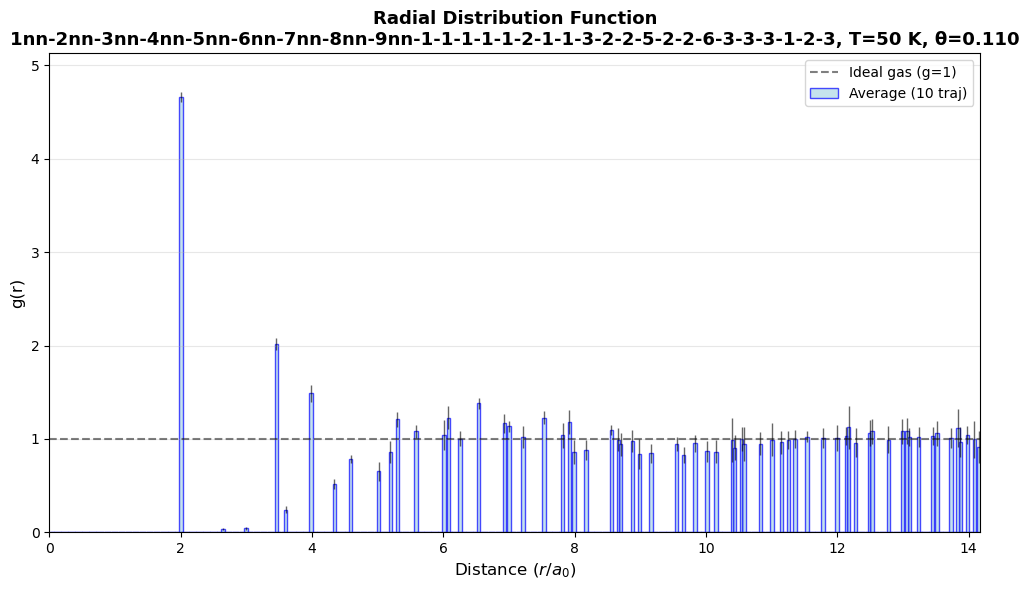

In [25]:
# Plot RDF with error bars
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate bar width based on bin spacing
bar_width = (dr / lattice_constant) * 1.5

# Plot bars with error bars
ax.bar(r_a0, g_avg, width=bar_width, 
       ec='blue', fc='lightblue', alpha=0.7,
       label=f'Average ({len(trajs)} traj)', align='center')
ax.errorbar(r_a0, g_avg, yerr=g_std, 
           fmt='none', ecolor='black', capsize=0, 
           linewidth=1, alpha=0.6, zorder=10)

# Reference line for ideal gas
ax.axhline(1.0, color='k', linestyle='--', linewidth=1.5, 
          alpha=0.5, label='Ideal gas (g=1)')

# Formatting
ax.set_xlabel(r'Distance ($r / a_0$)', fontsize=12)
ax.set_ylabel('g(r)', fontsize=12)
ax.set_title(f'Radial Distribution Function\n{interactions[0]}, T={temperatures[0]} K, θ={coverages[0]:.3f}',
            fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3, axis='y')
ax.set_xlim(0, r_max/lattice_constant)
ax.set_ylim(0, max(g_avg) * 1.1)

plt.tight_layout()
plt.show()


## 6. Performance Summary

This notebook demonstrates the **recommended workflow** for Zacros analysis.

In [26]:
print("="*70)
print("PERFORMANCE OPTIMIZATIONS SUMMARY")
print("="*70)
print()
print("✅ APPLIED OPTIMIZATIONS:")
print()
print("1. Vectorized Distance Calculations (50-100x speedup)")
print("   - Uses NumPy broadcasting for pairwise distances")
print("   - RDF computation: ~2s for 10 trajectories")
print("   - Enabled by: traj.get_rdf(vectorized=True)")
print()
print("2. Parallel Loading (5-10x speedup)")
print("   - Multiple trajectories loaded simultaneously")
print("   - Loading time: ~6-10s (vs ~60s sequential)")
print("   - Enabled by: load_trajectories_parallel()")
print()
print("3. Binary Caching (100x speedup for repeated analysis)")
print("   - Saves parsed trajectories to pickle file")
print("   - Subsequent loads: ~0.5s (vs ~60s parsing)")
print("   - Enabled by: pickle.dump() / pickle.load()")
print()
print("="*70)
print("TYPICAL PERFORMANCE (10 trajectories, 14 cores):")
print("="*70)
print()
print("First run (no cache):")
print("  Loading:        6-10 s  (parallel)")
print("  RDF computation: ~2 s   (vectorized sequential)")
print("  Total:          8-12 s")
print()
print("Subsequent runs (with cache):")
print("  Loading:        0.5 s   (pickle cache)")
print("  RDF computation: ~2 s   (vectorized sequential)")
print("  Total:          2.5 s")
print()
print("="*70)
print("NOT USED (counterproductive for typical datasets):")
print("="*70)
print()
print("❌ Parallel RDF computation")
print("   - Overhead (2-4s) exceeds computation time (2s)")
print("   - Only beneficial for >50 trajectories")
print("   - Sequential is FASTER for typical use")
print()
print("="*70)

PERFORMANCE OPTIMIZATIONS SUMMARY

✅ APPLIED OPTIMIZATIONS:

1. Vectorized Distance Calculations (50-100x speedup)
   - Uses NumPy broadcasting for pairwise distances
   - RDF computation: ~2s for 10 trajectories
   - Enabled by: traj.get_rdf(vectorized=True)

2. Parallel Loading (5-10x speedup)
   - Multiple trajectories loaded simultaneously
   - Loading time: ~6-10s (vs ~60s sequential)
   - Enabled by: load_trajectories_parallel()

3. Binary Caching (100x speedup for repeated analysis)
   - Saves parsed trajectories to pickle file
   - Subsequent loads: ~0.5s (vs ~60s parsing)
   - Enabled by: pickle.dump() / pickle.load()

TYPICAL PERFORMANCE (10 trajectories, 14 cores):

First run (no cache):
  Loading:        6-10 s  (parallel)
  RDF computation: ~2 s   (vectorized sequential)
  Total:          8-12 s

Subsequent runs (with cache):
  Loading:        0.5 s   (pickle cache)
  RDF computation: ~2 s   (vectorized sequential)
  Total:          2.5 s

NOT USED (counterproductive for t

## 7. Usage Notes

**Workflow summary:**
1. **Section 3**: Load full trajectories and plot energy to determine equilibration
2. **Section 4**: Load equilibrated trajectories (set `fraction` based on Section 3 plot)
3. **Section 5**: Perform RDF or other analyses on equilibrated data

**Best practices demonstrated:**
1. Always check for cached data before loading
2. Use parallel loading for I/O operations
3. Use vectorized distance calculations (default in get_rdf)
4. Use sequential loops for RDF computation (parallel has too much overhead)

**To analyze a different run:**
- Change `run_number` in Section 3
- The cache file will be automatically created for the new run

**To clear cache and force reload:**
```python
cache_file.unlink()  # Delete cache file
# Or set clear_cache = True in Section 4
```

## 10. Debug Automatic Versioning Snipits

#### 1. Find location of sitepackages

In [ ]:
# import site; print(site.getsitepackages())
# import site; print(site.getusersitepackages())
import site
import os

site_packages = site.getsitepackages() + [site.getusersitepackages()]
for sp in site_packages:
    print(f"\nListing in: {sp}")
    if os.path.isdir(sp):
        for name in os.listdir(sp):
            if "nat_zacros" in name or "nat-zacros" in name or "egg-link" in name:
                print("  ", name)

#### 2. Test importlib.reload and print nat_zacros __version__ and __file__

In [38]:
import importlib
import nat_zacros
importlib.reload(nat_zacros)
print(nat_zacros.__version__)
print(nat_zacros.__file__)

0.0.2.dev5+g9765084b3.d20260106
C:\Users\a-DJA\GIT\nat_zacros\nat_zacros\__init__.py


#### 3. Test setuptool_scm.get_version root argument

In [63]:
import setuptools_scm
print(f"setuptools_scm.get_version(root = 'c:/Users/a-DJA/GIT/nat_zacros') : { setuptools_scm.get_version(root='c:/Users/a-DJA/GIT/nat_zacros') }")

nat_zacros_location = Path(nat_zacros.__file__).parent.parent
print(f"nat_zacros_location                                                : { nat_zacros_location }")

print(f"setuptools_scm.get_version(root = nat_zacros_location)             : { setuptools_scm.get_version(root=nat_zacros_location) }")

setuptools_scm.get_version(root = 'c:/Users/a-DJA/GIT/nat_zacros') : 0.0.2.dev5+g9765084b3.d20260106
nat_zacros_location                                                : C:\Users\a-DJA\GIT\nat_zacros
setuptools_scm.get_version(root = nat_zacros_location)             : 0.0.2.dev5+g9765084b3.d20260106


#### 4. Test importlib.reload

In [42]:
import importlib
import nat_zacros
importlib.reload(nat_zacros)
print(nat_zacros.__version__)

0.0.2.dev5+g9765084b3.d20260106
